In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from numba import njit
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
from cycler import cycler
from scipy.signal import find_peaks
from ipywidgets import interact

In [10]:
from analysis_routines import *
from plotting_routines_xr import *
from harmonic_analysis import *
from wavelet_analysis import wavelet_power_spectrum
from processing_routines import datenum_to_epoch
plt.style.use('/home/manu/TFG_repo/notebooks/mplstyles/notebook.mplstyle')
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf

## Notebook structure and content:
3 periods that exhibit clear tidal variability without strong influence of other processes are selected. For each of them, a spectrogram is computed via the multitapper method. Then the semi diurnal oscilation of D1 and G005 is explored visually applyng diferent filteres to the signal. A single semi-diurnal oscillation is selected and 4 vertical profiles in this interval are ploted. 

In [7]:
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
data_chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
G005 = pd.read_csv(data_dir / 'SHDR_fit/aux/G05.csv', index_col='date', parse_dates=True)
delta005 = pd.read_csv(data_dir / 'SHDR_fit/aux/delta05_ci.csv', index_col='date', parse_dates=True)
bot_pres = pd.read_csv(data_dir / 'time_series/pressure_sensor/20181116_DanoisMoat.csv', 
                       index_col='date', parse_dates=True)

G005_ci = pd.read_csv(data_dir / 'SHDR_fit/aux/G05_ci.csv', index_col='date', parse_dates=True)

In [13]:
D1_ = fit_chain.D1
G005_ = G005.x

D1_filt512 = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, 1/512)
G005_filt512 = lowpass_filter(G005.x, data_chain.date, 1/5, 1/512)

D1_filt1024 = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, 1/1024)
G005_filt1024 = lowpass_filter(G005.x, data_chain.date, 1/5, 1/1024)

low = period_to_freq(14, 'h')
high = period_to_freq(8, 'h')
D1_bandpass_M2 = bandpass_filter(fit_chain.D1, data_chain.date, 1/5, low, high)
G005_bandpass_M2 = bandpass_filter(G005.x, data_chain.date, 1/5, low, high)

D1_dn = detrend_normalize(D1_bandpass_M2)
G005_dn = detrend_normalize(G005_bandpass_M2)

hi = period_to_freq(6, 'h')
G005_filt6h = lowpass_filter(G005.x, data_chain.date, 1/5, hi)
D1_filt6h = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, hi)

In [14]:
# dates defining_periods
date_0 = datetime(2018, 11, 16, 11) # period_1
date_1 = datetime(2018, 11, 24)
period_1 = [date_0, date_1]

date_2 = datetime(2018, 11, 30) # period_2
date_3 = datetime(2018, 12, 9)
period_2 = [date_2, date_3]

date_4 = datetime(2019, 1, 5) # period_3
date_5 = datetime(2019, 1, 14)
period_3 = [date_4, date_5]

In [15]:
coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(data_chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24
M6_cpd = 1/4.14020*24

## Period_1

<IPython.core.display.Javascript object>


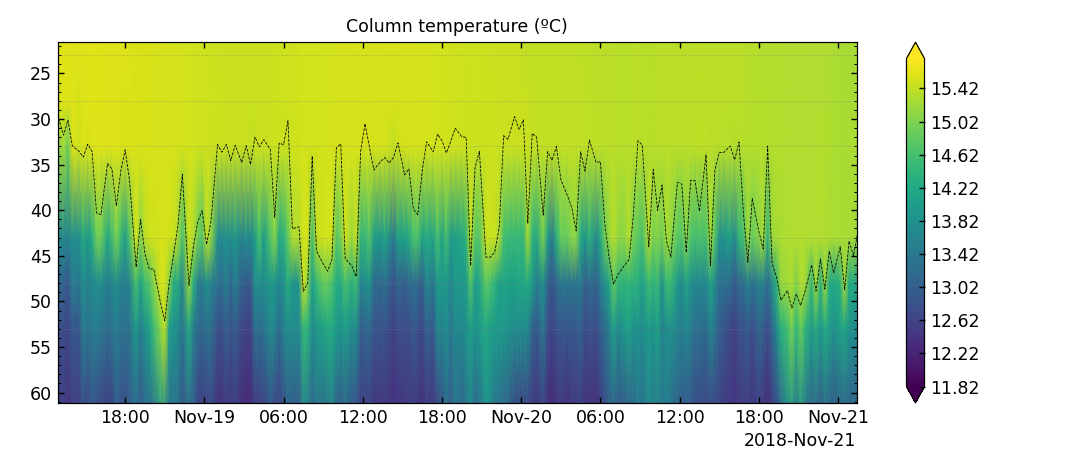

<IPython.core.display.Javascript object>


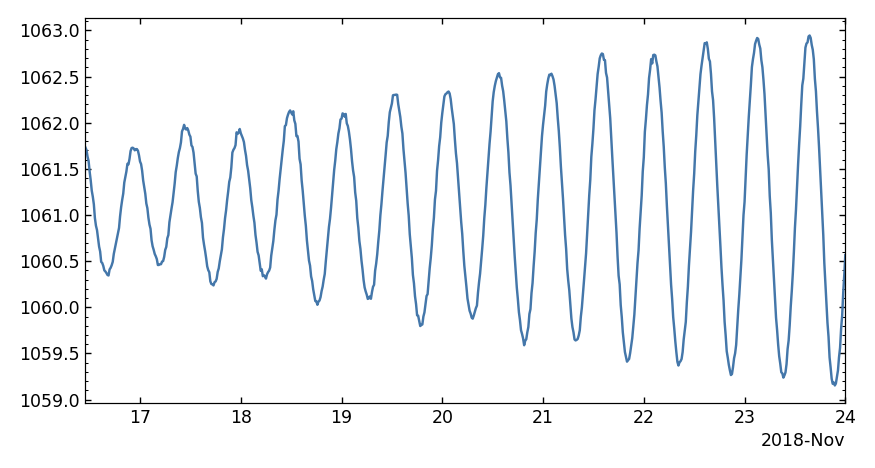

In [17]:
plot_column_temperature(data_chain, fit_chain, period=period_1, ylims=[120, 0])
plot_arbitrary_variable(bot_pres.pres, period=period_1, type='plot')

In [19]:
p1D_freqs, p1D_psd, p1D_dof = multitapping_spectrum(D1_[:date_1].to_numpy(), 5/60/60/24, 3)
p1G_freqs, p1G_psd, p1G_dof = multitapping_spectrum(G005_[:date_1].to_numpy(), 5/60/60/24, 3)

DPSS using interpolation 130321 100000
DPSS using interpolation 130321 100000


/home/manu/TFG_repo/scripts/plotting_routines_xr.py:452: RuntimeWarning: divide by zero encountered in true_divide
  period = 1/freqs


<IPython.core.display.Javascript object>


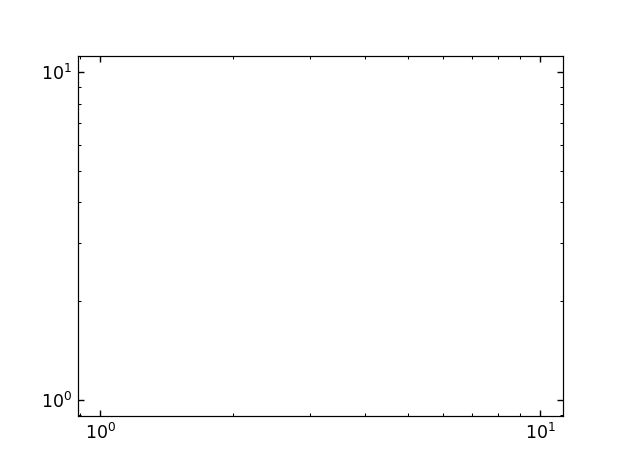

ValueError: x and y must have same first dimension, but have shapes (130322, 1) and (130320,)

In [20]:
plot_spectrum(p1D_freqs, p1D_psd, p1D_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(3e-3, 3e1), 
              vlines=[M2_cpd, coriolis_freq_cpd])

<IPython.core.display.Javascript object>


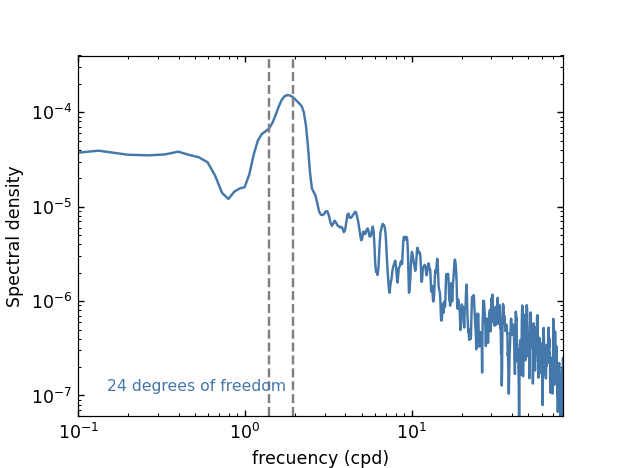

In [12]:
plot_spectrum(p1G_freqs, p1G_psd, p1G_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(6e-8, 4e-4), 
              vlines=[M2_cpd, coriolis_freq_cpd])

<IPython.core.display.Javascript object>


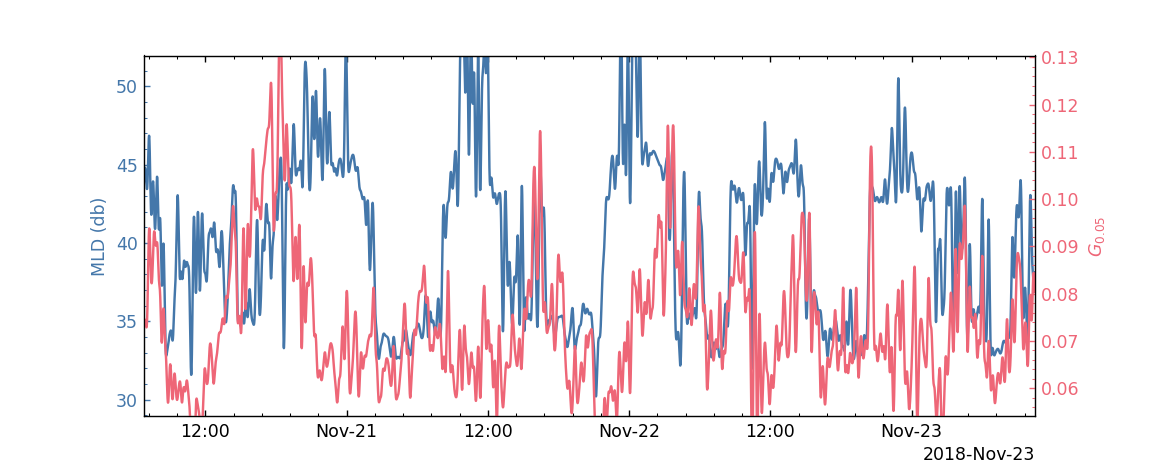

<IPython.core.display.Javascript object>


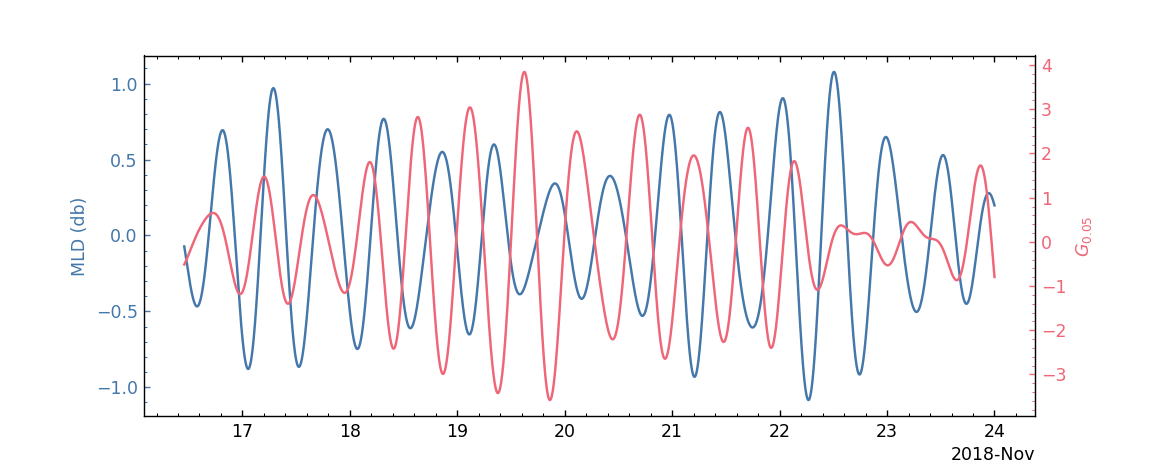

In [21]:
plot_D1_and_G005(D1_filt1024, G005_filt1024, period=period_1)
plot_D1_and_G005(D1_dn, G005_dn, period=period_1)

<IPython.core.display.Javascript object>


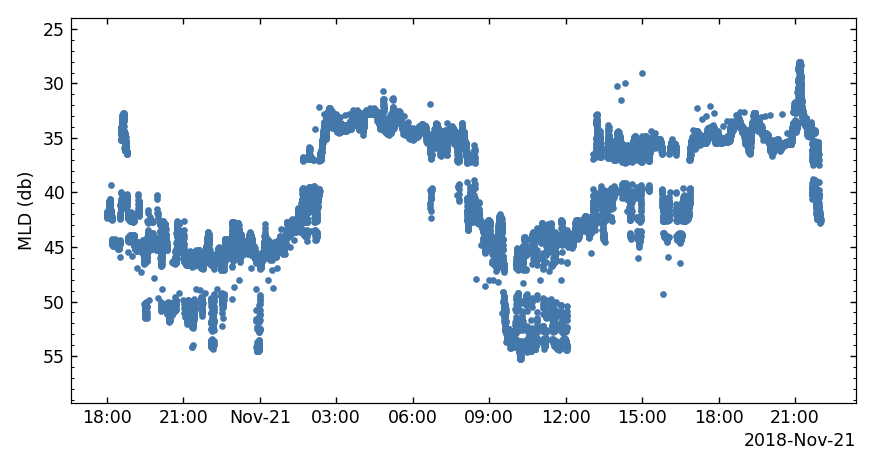

In [14]:
plot_fit_variable(fit_chain, 'D1', period=[datetime(2018, 11, 20, 18), datetime(2018, 11, 21, 22)])

<IPython.core.display.Javascript object>


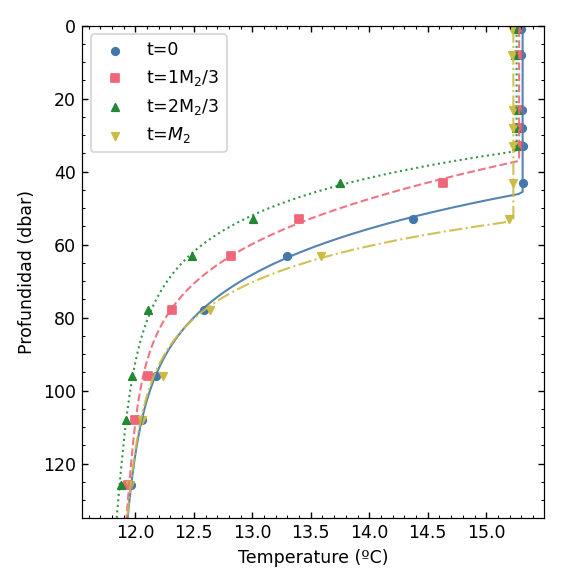

In [15]:
ref_date = datetime(2018, 11, 20, 21, 32, 10)
i_dates = [ref_date + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
#i_dates = [ref_date + timedelta(hours=i*12.4/4) for i in range(4)]

plot_multiple_profiles_ax(fit_chain, data_chain, i_dates)

<IPython.core.display.Javascript object>


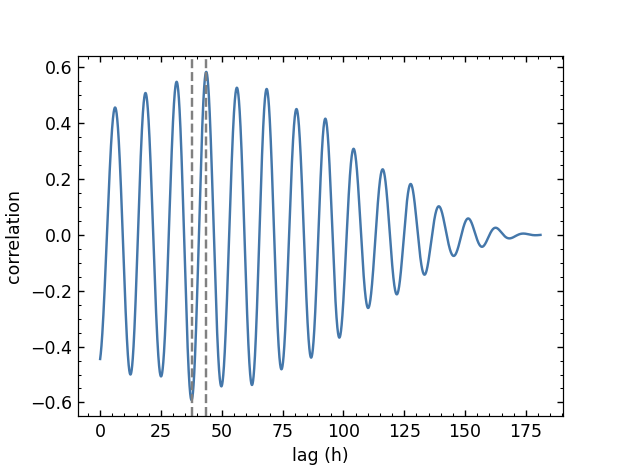

[  6.14027778  18.64027778  31.43333333  43.60972222  56.20416667
  68.44444444  80.69583333  92.55972222 104.17361111 116.125
 127.63055556 139.19722222 151.27777778]
37.56111111111111
43.609722222222224


In [16]:
lag_correlation(D1_dn, G005_dn, period=period_1)

## Period_2

<IPython.core.display.Javascript object>


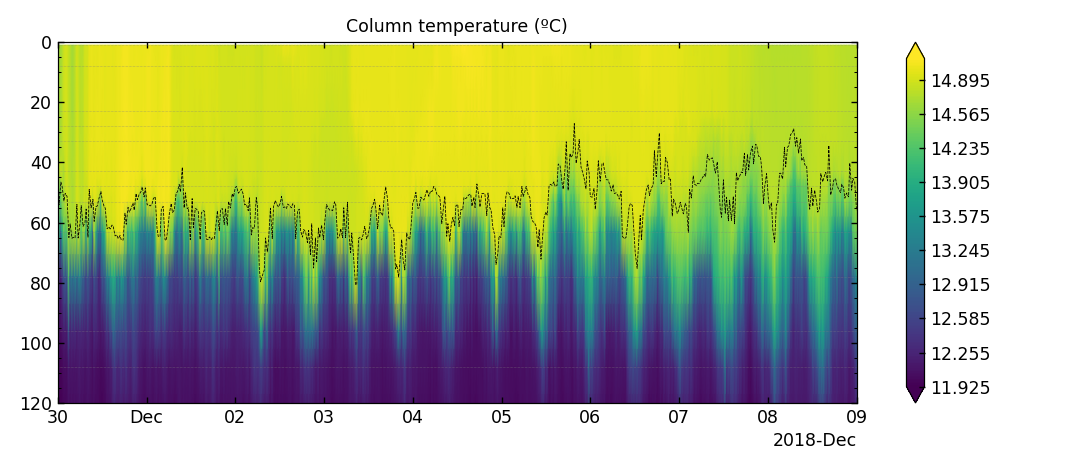

<IPython.core.display.Javascript object>


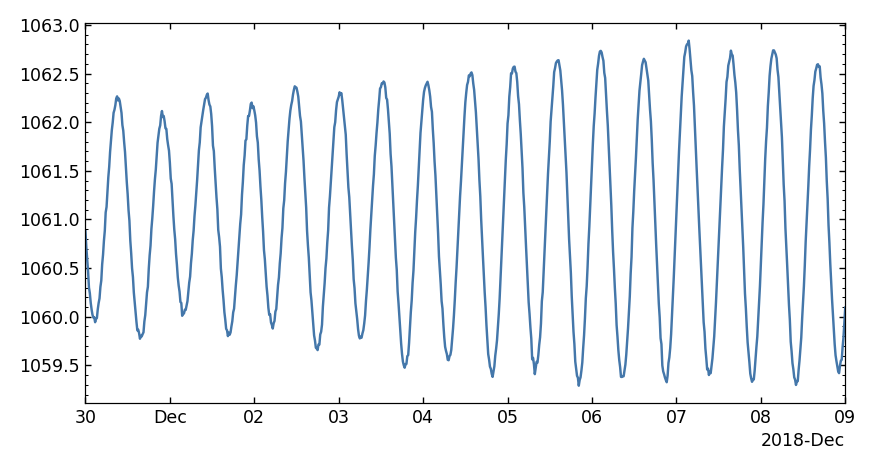

In [17]:
plot_column_temperature(data_chain, fit_chain, period=period_2, ylims=[120, 0])
plot_arbitrary_variable(bot_pres.pres, period=period_2, type='plot')

In [18]:
p2D_freqs, p2D_psd, p2D_dof = multitapping_spectrum(D1_[date_2:date_3].to_numpy(), 5/60/60/24, 3)
p2G_freqs, p2G_psd, p2G_dof = multitapping_spectrum(G005_[date_2:date_3].to_numpy(), 5/60/60/24, 3)

DPSS using interpolation 155521 100000
DPSS using interpolation 155521 100000


<IPython.core.display.Javascript object>


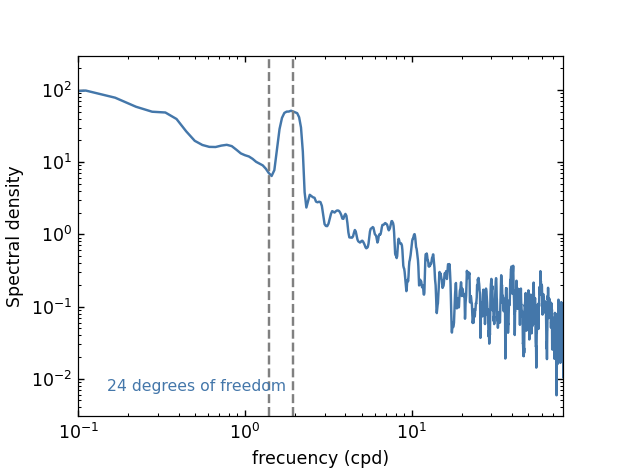

In [19]:
plot_spectrum(p2D_freqs, p2D_psd, p2D_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(3e-3, 3e2), 
              vlines=[M2_cpd, coriolis_freq_cpd])

<IPython.core.display.Javascript object>


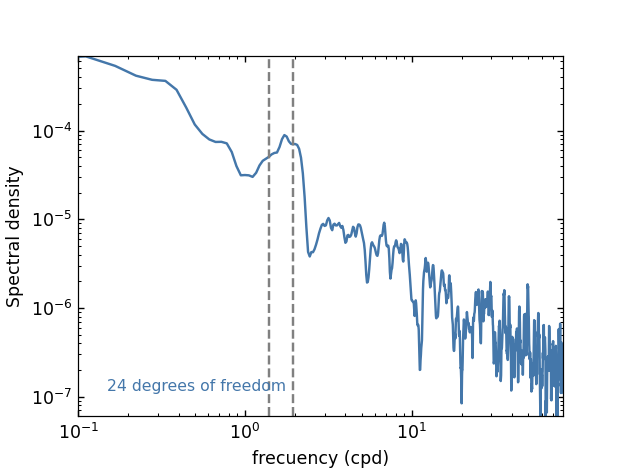

In [20]:
plot_spectrum(p2G_freqs, p2G_psd, p2G_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(6e-8, 7e-4), 
              vlines=[M2_cpd, coriolis_freq_cpd])

<IPython.core.display.Javascript object>


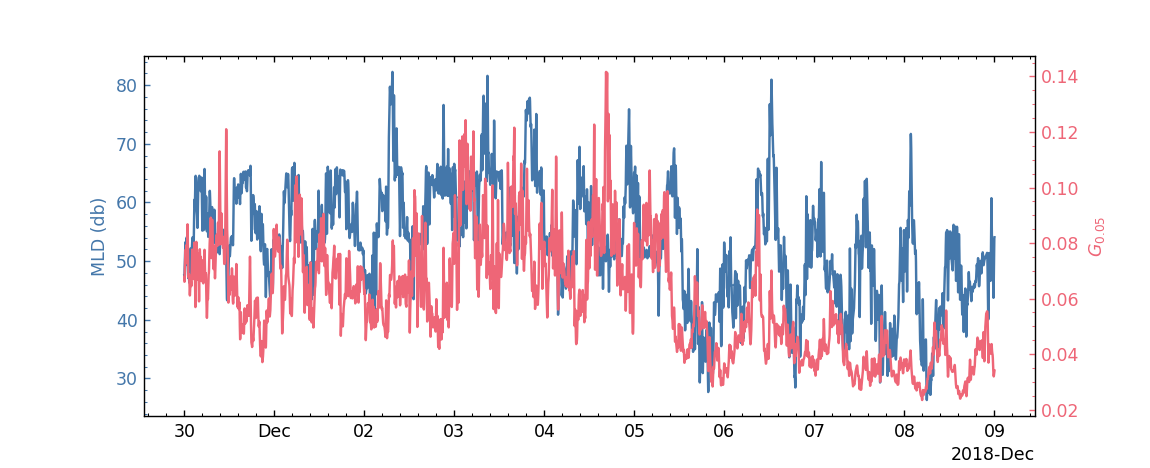

<IPython.core.display.Javascript object>


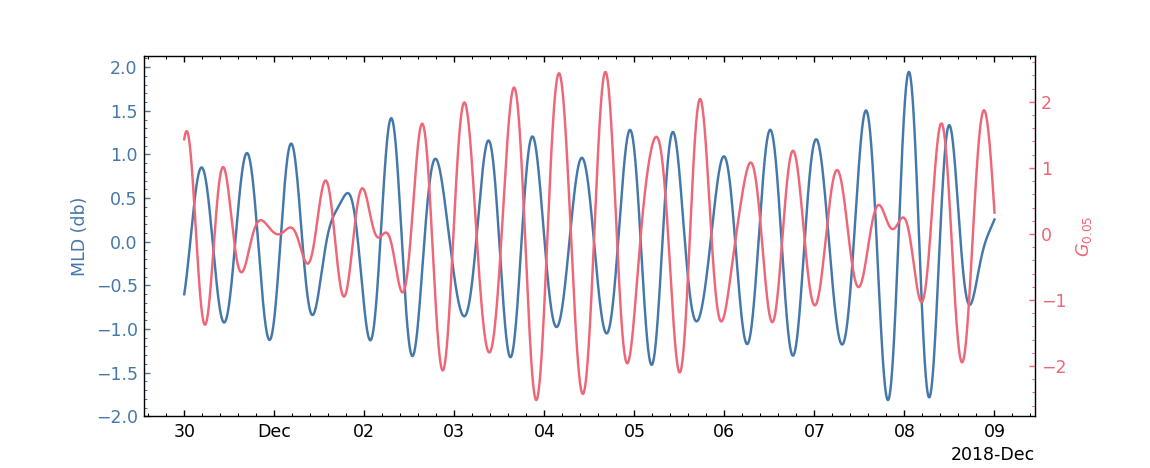

In [21]:
plot_D1_and_G005(D1_filt1024, G005_filt1024, period=period_2)
plot_D1_and_G005(D1_dn, G005_dn, period=period_2)

<IPython.core.display.Javascript object>


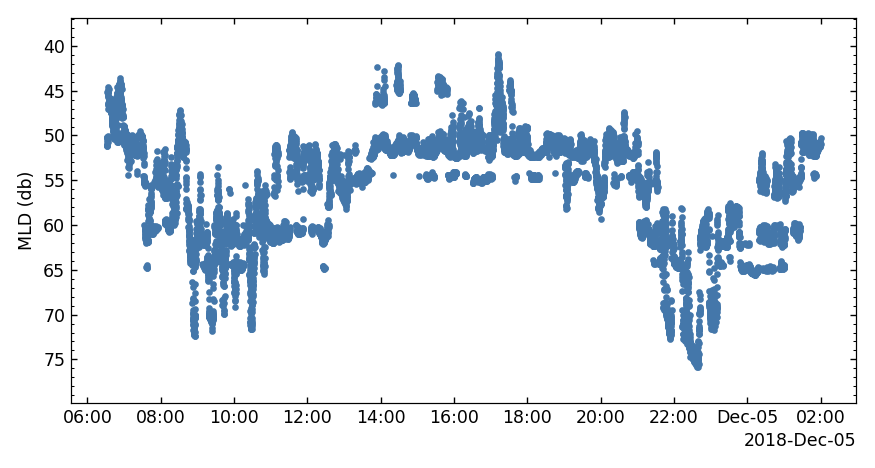

In [22]:
plot_fit_variable(fit_chain, 'D1', period=[datetime(2018, 12, 4, 6, 32, 10), datetime(2018, 12, 5, 2)])

<IPython.core.display.Javascript object>


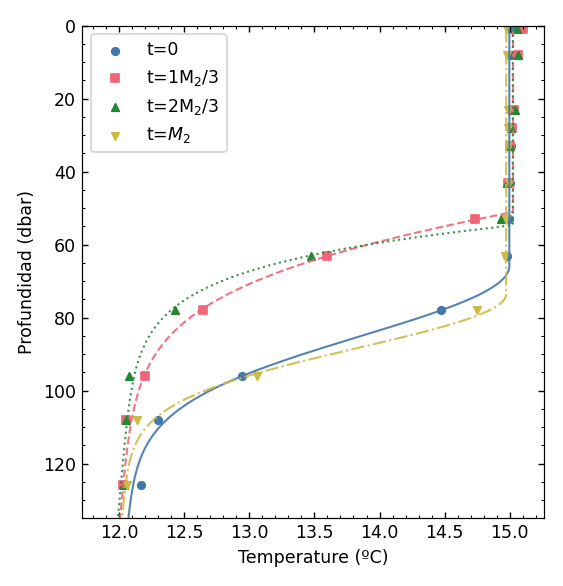

In [23]:
#ref_date = datetime(2018, 12, 3, 20, 4, 10)
ref_date = datetime(2018, 12 ,4, 9, 59, 40)
i_dates = [ref_date + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
plot_multiple_profiles_ax(fit_chain, data_chain, i_dates)

<IPython.core.display.Javascript object>


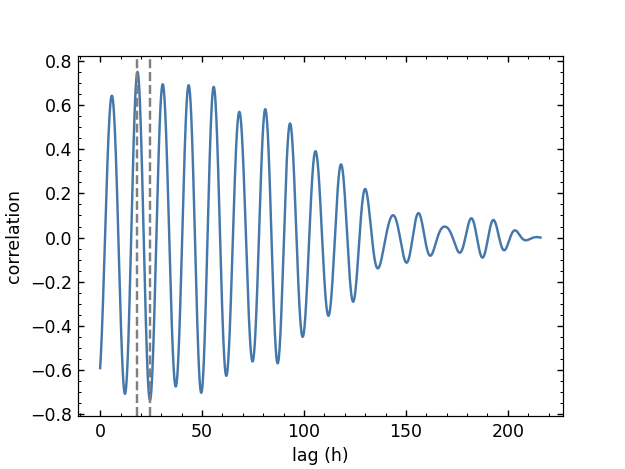

[  5.74166667  18.31388889  30.68888889  43.40833333  55.7125
  68.27361111  81.00833333  93.15138889 105.64166667 118.15972222
 129.99444444 143.69166667 156.15555556 169.02361111 182.09722222
 192.89722222]
24.43472222222222
18.313888888888886


In [24]:
lag_correlation(D1_dn, G005_dn, period=period_2)

<IPython.core.display.Javascript object>


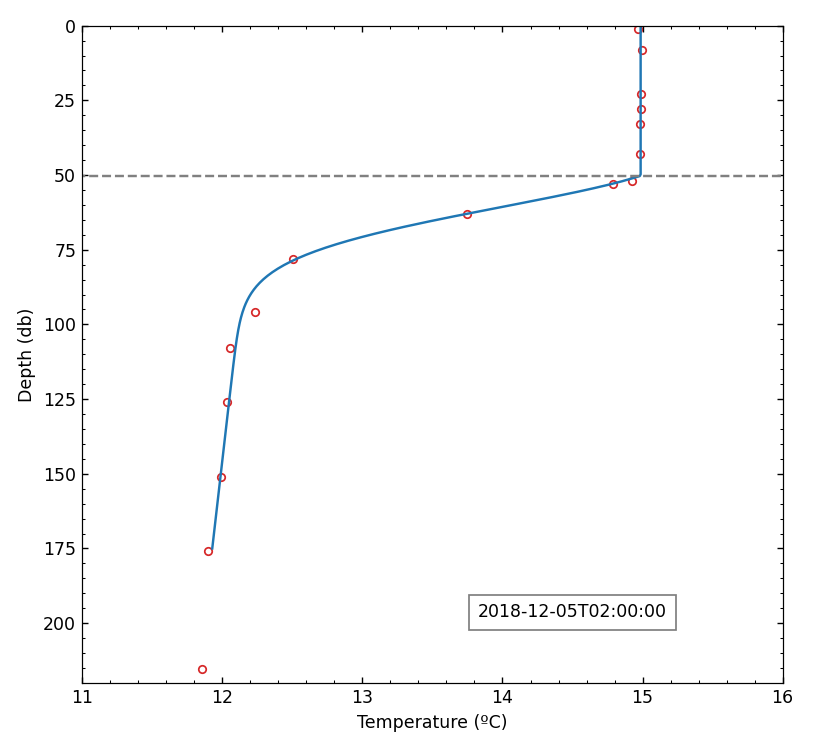

In [25]:
animate_profile_evolution(fit_chain, data_chain, 'period_2_precise.mp4', 
                          period=[datetime(2018, 12, 4, 6, 32, 10), datetime(2018, 12, 5, 2)], num_plots=600)

In [26]:
display_video('period_2_tides.mp4')

In [27]:
display_video('period_2_precise.mp4')

## Period_3

<IPython.core.display.Javascript object>


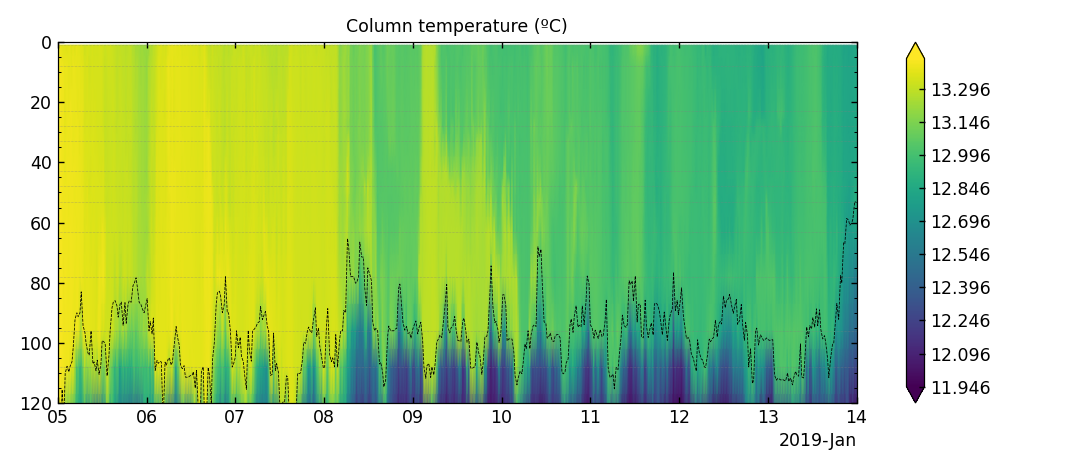

/home/manu/TFG_repo/scripts/plotting_routines_xr.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(7, 3.75))


<IPython.core.display.Javascript object>


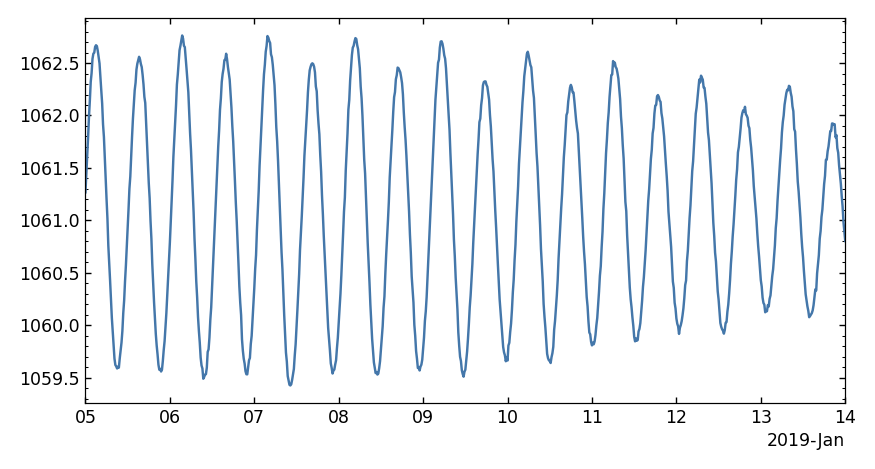

In [28]:
plot_column_temperature(data_chain, fit_chain, period=period_3, ylims=[120, 0])
plot_arbitrary_variable(bot_pres.pres, period=period_3, type='plot')

In [29]:
p3D_freqs, p3D_psd, p3D_dof = multitapping_spectrum(D1_[date_4:date_5].to_numpy(), 5/60/60/24, 3)
p3G_freqs, p3G_psd, p3G_dof = multitapping_spectrum(G005_[date_4:date_5].to_numpy(), 5/60/60/24, 3)

DPSS using interpolation 155521 100000
DPSS using interpolation 155521 100000


<IPython.core.display.Javascript object>


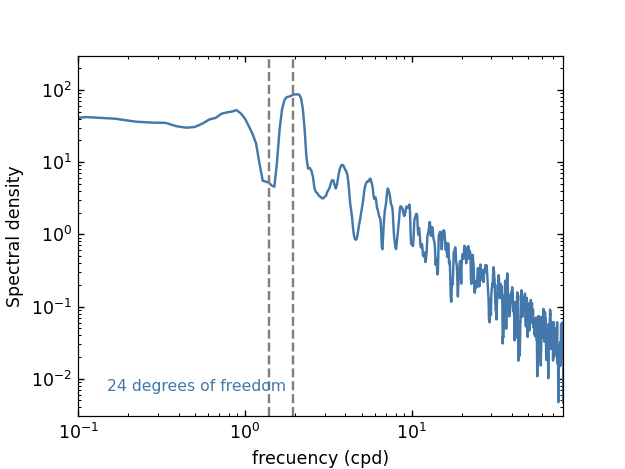

In [30]:
plot_spectrum(p3D_freqs, p3D_psd, p3D_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(3e-3, 3e2), 
              vlines=[M2_cpd, coriolis_freq_cpd])

<IPython.core.display.Javascript object>


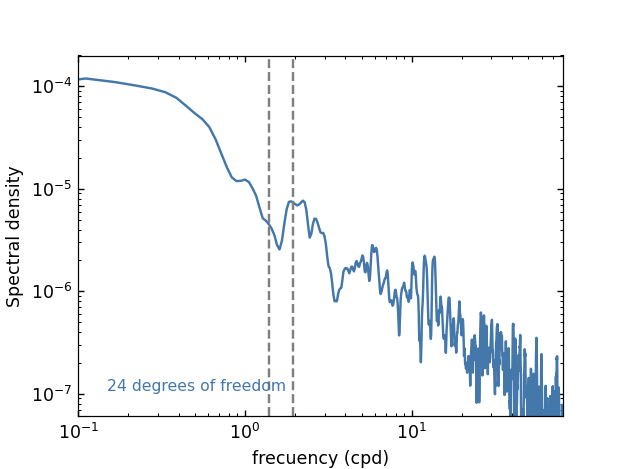

In [31]:
plot_spectrum(p3G_freqs, p3G_psd, p3G_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(6e-8, 2e-4), 
              vlines=[M2_cpd, coriolis_freq_cpd])

<IPython.core.display.Javascript object>


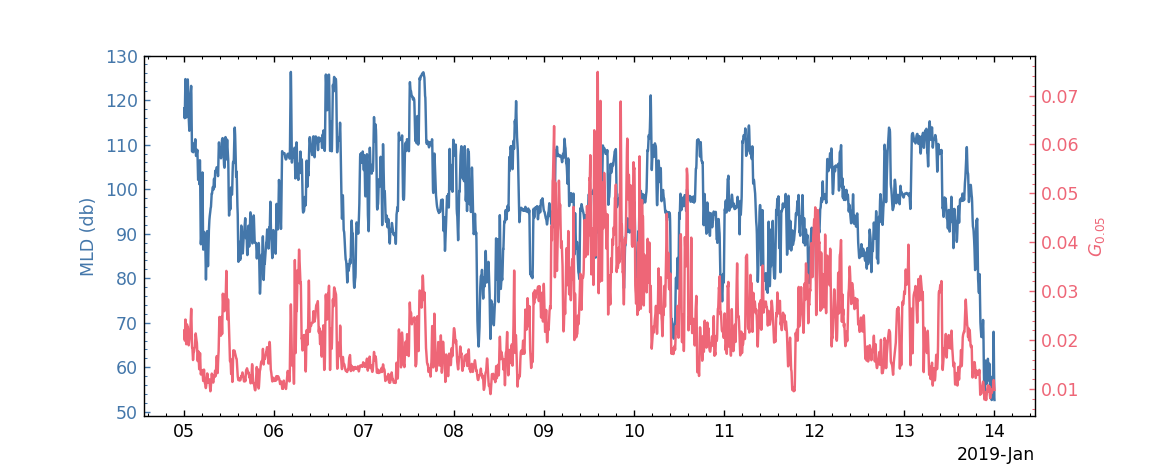

<IPython.core.display.Javascript object>


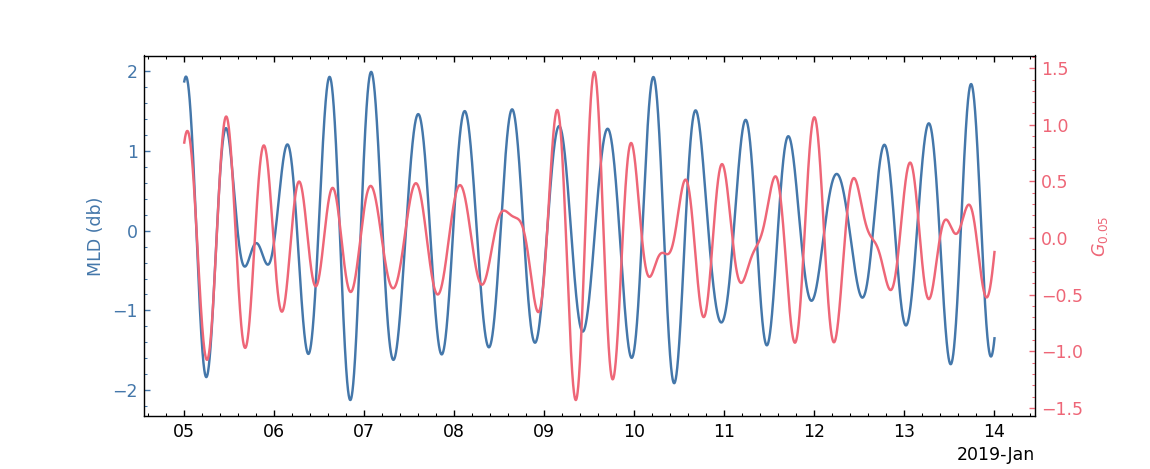

In [32]:
plot_D1_and_G005(D1_filt1024, G005_filt1024, period=period_3)
plot_D1_and_G005(D1_dn, G005_dn, period=period_3)

<IPython.core.display.Javascript object>


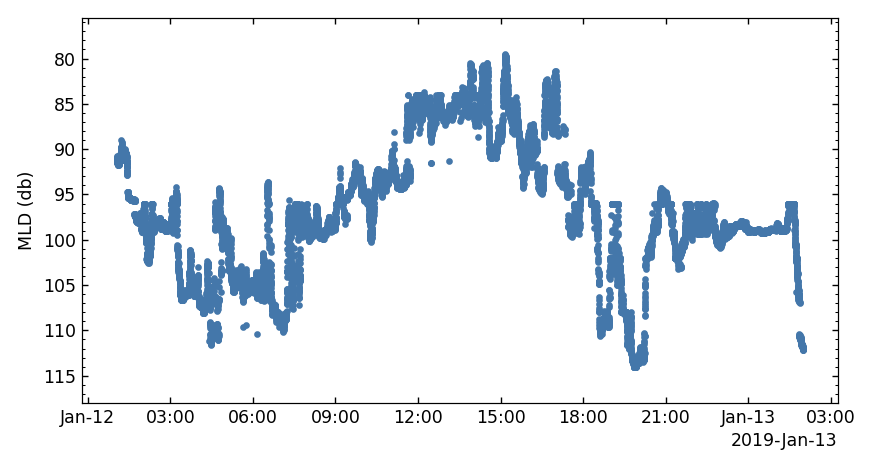

In [33]:
plot_fit_variable(fit_chain, 'D1', period=[datetime(2019, 1, 12, 1, 3, 10), datetime(2019, 1, 13, 2)])

[datetime.datetime(2019, 1, 12, 5, 55, 40), datetime.datetime(2019, 1, 12, 10, 4, 5), datetime.datetime(2019, 1, 12, 14, 12, 30), datetime.datetime(2019, 1, 12, 18, 20, 55)]


<IPython.core.display.Javascript object>


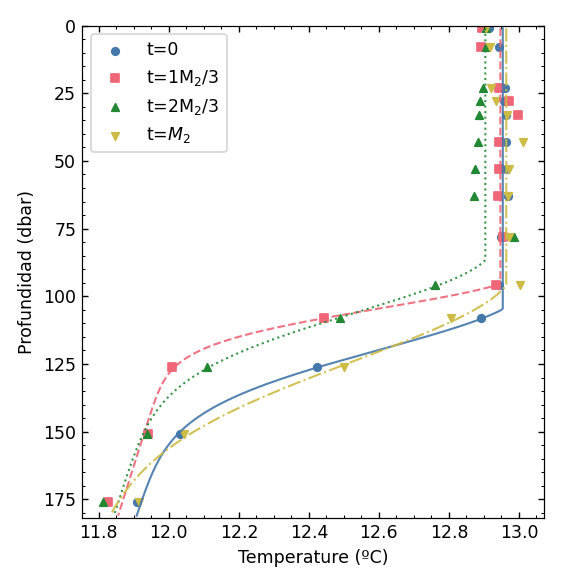

date
2019-01-12 05:55:40    0.020066
2019-01-12 10:04:05    0.032069
2019-01-12 14:12:30    0.017635
2019-01-12 18:20:55    0.014494
Name: x, dtype: float64


In [34]:
ref_date = datetime(2019, 1, 12, 5, 55, 40)
i_dates = [ref_date + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
print(i_dates)
plot_multiple_profiles_ax(fit_chain, data_chain, i_dates, ylim=(182, 0))
print(G005.x[i_dates])

<IPython.core.display.Javascript object>


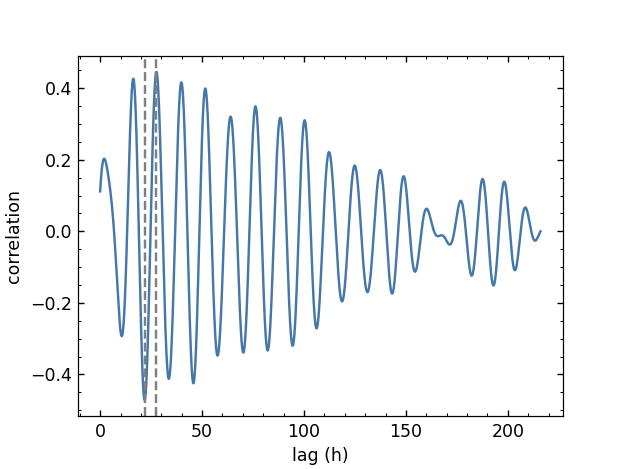

[  1.98194444  16.25416667  27.59305556  39.82777778  51.56944444
  63.98055556  76.19305556  88.34305556 100.30416667 112.28194444
 124.86944444 137.37916667 148.8625     160.11388889 176.89861111
 187.6        198.23194444 208.55416667]
21.829166666666666
27.593055555555555


In [35]:
lag_correlation(D1_dn, G005_dn, period=period_3)

In [1]:
from ipywidgets import Layout, interact, IntSlider

def interact_profile(data_chain, fit_chain, range_dates, dn=24):
    slice_ = slice(*range_dates, dn)
    temp_chain_range = data_chain.temp.loc[slice_].data
    date_chain_range = data_chain.date.loc[slice_].data
    fit_chain_range = fit_chain.loc[slice_]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    N = len(date_chain_range)
    
    int_wdgt = IntSlider(
    description='Number:',
    value=0,
    min=0, max=N-1, step=1,
    layout = Layout(width='100%'))
    
    zz = np.linspace(0, 200, 300)

    
    def plot_(i):
        fig = plt.figure(figsize=(4, 4.6875))
        plt.scatter(temp_chain_range[i], data_chain.depth, marker='o', fc='None', ec=colors[1], s=24)
        plt.plot(fit_function(zz, fit_chain_range, i), zz, lw=1)
        plt.title(np.datetime_as_string(date_chain_range[i], unit='s'))
        plt.ylim(200, 0)
        plt.show()
        del fig
        
    interact(plot_, i=int_wdgt)

In [9]:
interact_profile(data_chain, fit_chain, [datetime(2018, 11, 16, 11), datetime(2018, 11, 18, 11)], dn=1)

interactive(children=(IntSlider(value=0, description='Number:', layout=Layout(width='100%'), max=34560), Outpu…